## 机器学习模型动态增量训练

### 静态模型和动态模型
- 静态模型采用离线训练方式。一般只训练模型一次，然后长时间使用该模型。
- 动态模型采用在线训练方式。数据会不断进入系统，通过不断地更新系统将这些数据整合到模型中。

![Imgur](https://i.imgur.com/5bTAAg0.png)

scikit-learn 中，<a href="https://scikit-learn.org/stable/modules/computing.html#incremental-learning"><i class="fa fa-external-link-square" aria-hidden="true"> 支持增量训练</i></a> 的算法有：

- 分类算法
    - `sklearn.naive_bayes.MultinomialNB`
    - `sklearn.naive_bayes.BernoulliNB`
    - `sklearn.linear_model.Perceptron`
    - `sklearn.linear_model.SGDClassifier`
    - `sklearn.linear_model.PassiveAggressiveClassifier`
    - `sklearn.neural_network.MLPClassifier`

- 回归算法
    - `sklearn.linear_model.SGDRegressor`
    - `sklearn.linear_model.PassiveAggressiveRegressor`
    - `sklearn.neural_network.MLPRegressor`

下面，我们使用人工神经网络来完成模型动态增量训练及部署过程。这里同样选择前面用过的 DIGITS 手写字符数据集。为了实验的需要，我们将手写字符矩阵中大于 0 的值全部替换为 1。

In [2]:
from sklearn.datasets import load_digits

digits=load_digits()

digits.data.shape,digits.target.shape

((1797, 64), (1797,))

In [3]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(digits.data,digits.target,random_state=1,test_size=.2)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

model=MLPClassifier(random_state=1,verbose=1,max_iter=50)

model.fit(X_train,y_train)
y_pred=model.predict(X_test)
accuracy_score(y_test,y_pred)

Iteration 1, loss = 7.02205935
Iteration 2, loss = 3.65516147
Iteration 3, loss = 2.47679869
Iteration 4, loss = 1.49613624
Iteration 5, loss = 1.00259484
Iteration 6, loss = 0.72002813
Iteration 7, loss = 0.54341224
Iteration 8, loss = 0.43746627
Iteration 9, loss = 0.36224450
Iteration 10, loss = 0.30940686
Iteration 11, loss = 0.26808400
Iteration 12, loss = 0.23881533
Iteration 13, loss = 0.21317742
Iteration 14, loss = 0.19387023
Iteration 15, loss = 0.17858371
Iteration 16, loss = 0.16540074
Iteration 17, loss = 0.15237040
Iteration 18, loss = 0.14083022
Iteration 19, loss = 0.13015872
Iteration 20, loss = 0.12388636
Iteration 21, loss = 0.11475134
Iteration 22, loss = 0.10716270
Iteration 23, loss = 0.10093849
Iteration 24, loss = 0.09392212
Iteration 25, loss = 0.08891589
Iteration 26, loss = 0.08473752
Iteration 27, loss = 0.08024667
Iteration 28, loss = 0.07630452
Iteration 29, loss = 0.07093241
Iteration 30, loss = 0.06705022
Iteration 31, loss = 0.06426208
Iteration 32, los

/Users/rena/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.975

In [5]:
n=0

for i,(pred,test) in enumerate(zip(y_pred,y_test)):
    if pred!=test:
        print('样本索引：', i, '被错误预测为：',pred,'正确标签为：',test)
        n+=1
print('总计错误预测样本数量：',n)

样本索引： 21 被错误预测为： 4 正确标签为： 1
样本索引： 58 被错误预测为： 9 正确标签为： 5
样本索引： 88 被错误预测为： 9 正确标签为： 5
样本索引： 173 被错误预测为： 5 正确标签为： 8
样本索引： 208 被错误预测为： 4 正确标签为： 0
样本索引： 281 被错误预测为： 4 正确标签为： 0
样本索引： 321 被错误预测为： 4 正确标签为： 7
样本索引： 347 被错误预测为： 5 正确标签为： 8
样本索引： 348 被错误预测为： 3 正确标签为： 5
总计错误预测样本数量： 9


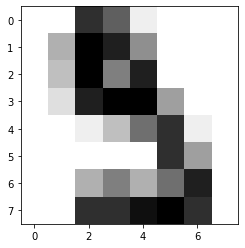

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X_test[108].reshape((8,8)),cmap=plt.cm.gray_r)

### 动态增量训练
scikit-learn 中，增量训练的方法是 `model.partial_fit(X, y)`，其使用方法与 `model.fit(X, y)` 别无二致。

In [7]:
import numpy as np

addition_index=[]

for i,(pred,test) in enumerate(zip(y_pred,y_test)):
    if pred!=test:
        addition_index.append(i)
        
addition_X=X_test[addition_index]
addition_y=y_test[addition_index]

model.partial_fit(addition_X,addition_y)
model

Iteration 51, loss = 2.24865593


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=1, warm_start=False)

In [8]:
y_pred=model.predict(X_test)
accuracy_score(y_test,y_pred)

n=0
for i,(pred,test) in enumerate(zip(y_pred,y_test)):
    if pred!=test:
        print('样本索引：', i, '被错误预测为：',pred,'正确标签为：',test)
        n+=1
print('总计错误预测样本数量：',n)

样本索引： 75 被错误预测为： 6 正确标签为： 4
样本索引： 88 被错误预测为： 9 正确标签为： 5
样本索引： 172 被错误预测为： 8 正确标签为： 3
样本索引： 173 被错误预测为： 5 正确标签为： 8
样本索引： 229 被错误预测为： 2 正确标签为： 3
样本索引： 248 被错误预测为： 8 正确标签为： 3
样本索引： 249 被错误预测为： 5 正确标签为： 7
样本索引： 281 被错误预测为： 4 正确标签为： 0
样本索引： 347 被错误预测为： 5 正确标签为： 8
总计错误预测样本数量： 9


In [9]:
#copy and paste
from IPython.display import HTML

input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 43px; height: 44px;">
<canvas width="40" height="40"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">重绘</button>
</td>
</table>
"""

javascript = '''
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 8*8; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 5, 5);
            x = Math.floor(e.offsetY * 0.2);
            y = Math.floor(e.offsetX * 0.2) + 1;
            for (var dy = 0; dy < 1; dy++){
                for (var dx = 0; dx < 1; dx++){
                    if ((x + dx < 8) && (y + dy < 8)){
                        pixels[(y+dy)+(x+dx)*8] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value();
            click = 0;
        }
    });
    
    function set_value(){
        var result = ""
        for (var i = 0; i < 8*8; i++) result += pixels[i] + ","
        var kernel = IPython.notebook.kernel;
        kernel.execute("image = [" + result + "]");
        kernel.execute("f = open('digits.json', 'w')");
        kernel.execute("f.write('{\\"inputs\\":%s}' % image)");
        kernel.execute("f.close()");
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 40, 40);
        for (var i = 0; i < 8*8; i++) pixels[i] = 0;
    }
</script>
'''
randint = np.random.randint(0, 9)
print("请在下方图框中细心绘制手写字符 {randint}")
HTML(input_form + javascript)

请在下方图框中细心绘制手写字符 6


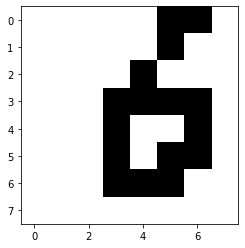

In [13]:
import json
import numpy as np

with open('digits.json') as f:
    inputs=f.readlines()[0]
    inputs_array=np.array(json.loads(inputs)['inputs'])
plt.imshow(inputs_array.reshape((8,8)),cmap=plt.cm.gray_r)

In [15]:
digits.data[digits.data>0]=1
model=MLPClassifier(tol=.001,max_iter=50,verbose=1)
model.fit(digits.data,digits.target)

Iteration 1, loss = 2.33868846
Iteration 2, loss = 2.11539911
Iteration 3, loss = 1.93291806
Iteration 4, loss = 1.75265696
Iteration 5, loss = 1.57276448
Iteration 6, loss = 1.39193571
Iteration 7, loss = 1.22789088
Iteration 8, loss = 1.08499332
Iteration 9, loss = 0.96293545
Iteration 10, loss = 0.86495487
Iteration 11, loss = 0.78125474
Iteration 12, loss = 0.71285892
Iteration 13, loss = 0.65713071
Iteration 14, loss = 0.60921482
Iteration 15, loss = 0.56962371
Iteration 16, loss = 0.53302576
Iteration 17, loss = 0.50282273
Iteration 18, loss = 0.47834713
Iteration 19, loss = 0.45562551
Iteration 20, loss = 0.43499705
Iteration 21, loss = 0.41707431
Iteration 22, loss = 0.40100169
Iteration 23, loss = 0.38686010
Iteration 24, loss = 0.37402078
Iteration 25, loss = 0.36225797
Iteration 26, loss = 0.35297692
Iteration 27, loss = 0.34348046
Iteration 28, loss = 0.33366251
Iteration 29, loss = 0.32573492
Iteration 30, loss = 0.31846702
Iteration 31, loss = 0.31202449
Iteration 32, los

/Users/rena/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.001, validation_fraction=0.1, verbose=1, warm_start=False)

In [17]:
inputs_array =np.atleast_2d(inputs_array)  #2d array
result=model.predict(inputs_array) 

if result != randint:
    print(f"预测错误｜预测标签: {result}｜真实标签: {randint}")
    model.partial_fit(inputs_array, np.atleast_1d(randint))
    print("完成增量训练")
else:
    print(f"预测正确｜预测标签: {result}｜真实标签: {randint}")
    model.partial_fit(inputs_array, np.atleast_1d(randint))
    print("完成增量训练")

预测错误｜预测标签: [7]｜真实标签: 6
Iteration 51, loss = 6.47393184
完成增量训练


<BarContainer object of 10 artists>

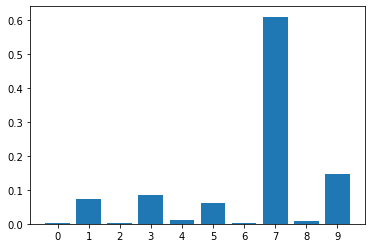

In [18]:
# 概率值
pred_proba=model.predict_proba(np.atleast_2d(inputs_array))

plt.xticks(range(10))
plt.bar(range(10),pred_proba[0],align='center')